<div style="background-color: #13678A; 
            color: white; 
            padding: 10px; 
            text-align: center;
            font-size: 20px;">
    <h1>Análise de RFM e Clusterização</h1>
</div>

# Introdução
Este conjunto de dados abrangente que oferece uma ampla gama de informações relacionadas a vendas no varejo online fornece uma análise detalhada de transações, detalhes de produtos e informações de clientes documentadas por uma empresa de **varejo online sediada no Reino Unido**. O escopo dos dados é vasto, desde detalhes específicos sobre cada produto vendido até extensos conjuntos de dados de clientes de diferentes países. 

<div style="background-color: #13678A; 
            color: white; 
            padding: 10px; 
            text-align: center;
            font-size: 20px;">
    <h1>1. Importando Bibliotecas e Dataset</h1>
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import plotly.express as px
import utils.funcoes as func
import seaborn as sns

In [2]:
df = pd.read_csv("data/online_retail.csv", sep=",")
display(df)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


A seguir a paleta de cor customizada que será utilizada no decorrer deste projeto.

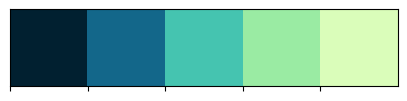

In [3]:
Poseidon = ["#012030", "#13678A", "#45C4B0", "#9AEBA3", "#DAFDBA"]
sns.set_palette(Poseidon)
sns.palplot(Poseidon)

## 1.1 Descrição do Dataset
- **Nº da fatura (InvoiceNo)** - Um número de 6 dígitos atribuído exclusivamente a cada transação. Se o número for precedido por 'C', indica um cancelamento. (Nominal)
- **Código do produto (StockCode)** - Um identificador único para cada produto vendido pelo varejista. (Nominal)
- **Descrição (Description)**	- O nome ou uma breve descrição do produto. (Nominal)
- **Quantidade (Quantity)** - Número de unidades do produto vendidas em cada transação. (Numérico)
- **Data da fatura (InvoiceDate)** - A data e a hora em que a transação foi realizada. (Data e hora)
- **Preço unitário (UnitPrice)** - Preço unitário do produto em libras esterlinas. (Numérico)
- **País (Country)** - País de residência do cliente. (Nominal)

In [4]:
func.df_summary_report(df)

,Coluna,Tipo,Quantidade de Dados Não Vazios,Quantidade de Dados Vazios,Valores Únicos,Porcentagem de Unicidade,Porcentagem de Valor Vazios (%)
0,index,int64,541909,0,541909,100.00,0.00
1,InvoiceNo,str,541909,0,25900,4.78,0.00
2,StockCode,str,541909,0,4070,0.75,0.00
3,Description,str,540455,1454,4223,0.78,0.27
4,Quantity,int64,541909,0,722,0.13,0.00
5,InvoiceDate,str,541909,0,23260,4.29,0.00
6,UnitPrice,float64,541909,0,1630,0.30,0.00
7,CustomerID,float64,406829,135080,4372,0.81,24.93
8,Country,str,541909,0,38,0.01,0.00


## 1.2 Análise Exploratória dos Dados e Tratamento dos Dados
Nesta seção serão abordadas estratégias para o tratamento de dados inconsistentes e ausentes, com o objetivo de garantir maior qualidade e confiabilidade às análises, preservando apenas as informações relevantes para o problema de negócio.

In [5]:
df.describe()

,index,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,541909.000000,406829.000000
mean,270954.000000,9.552250,4.611114,15287.690570
std,156435.797851,218.081158,96.759853,1713.600303
min,0.000000,-80995.000000,-11062.060000,12346.000000
25%,135477.000000,1.000000,1.250000,13953.000000
50%,270954.000000,3.000000,2.080000,15152.000000
75%,406431.000000,10.000000,4.130000,16791.000000
max,541908.000000,80995.000000,38970.000000,18287.000000


Foi identificada a existência de valores negativos nas variáveis `Quantity` e `UnitPrice`. Inicialmente, será realizada uma análise quantitativa dessas ocorrências para compreender sua magnitude e, posteriormente, investigar o que elas podem representar dentro do conjunto de dados.

In [6]:
uni_negativa = (df['UnitPrice'] < 0).sum()
print(f'Existem {uni_negativa} produtos listados com valor negativo')

quant_negativa = (df['Quantity'] < 0).sum()
print(f'Existem {quant_negativa} unidades de produtos com transações negativas')

Existem 2 produtos listados com valor negativo
Existem 10624 unidades de produtos com transações negativas


As transações com valores negativos provavelmente correspondem a cancelamentos ou devoluções, uma vez que o dataset registra quantidades negativas quando ocorre o estorno de produtos previamente adquiridos.

Além disso, conforme descrito na documentação do conjunto de dados, a coluna `InvoiceNo` identifica transações canceladas por meio da letra "C" no início do registro. Dessa forma, será realizada a verificação e quantificação dessas transações para compreender sua representatividade no dataset.

In [7]:
# Verifica a primeira 'letra'
verificacao = df['InvoiceNo'].str.startswith('C')
cont = verificacao.sum()
print(f'Existem {cont} transações que começam com C')

Existem 9288 transações que começam com C


Outra análise que pode ser feita é a verificação de produtos com `UnitPrice` igual a 0.

In [8]:
preco_zero = (df["UnitPrice"] == 0).sum()
print(f"Existem {preco_zero} produtos listados com preço zero.")

Existem 2515 produtos listados com preço zero.


A investigação dos dados revelou que os registros inconsistentes estão predominantemente associados a transações canceladas. Dessa forma, esses registros serão removidos a fim de evitar distorções na segmentação dos clientes.

In [9]:
#Exclur as transações canceladas
df = df[~verificacao]

Após excluir os dados associados a transações de foram registradas como canceladas, podemos novamente fazer outra verificação encima do valores negativos presente no dataset. 

In [10]:
quant_negativa = (df['Quantity'] < 0).sum()
print(f'Existem {quant_negativa} unidades de produtos com transações negativas')
uni_negativa = (df['UnitPrice'] < 0).sum()
print(f'Existem {uni_negativa} produtos listados com valor negativo')
preco_zero = (df["UnitPrice"] == 0).sum()
print(f"Existem {preco_zero} produtos listados com preço zero.")

Existem 1336 unidades de produtos com transações negativas
Existem 2 produtos listados com valor negativo
Existem 2515 produtos listados com preço zero.


Ainda existem valores negativos e produtos com preço zero no nosso dataset, irei excluir esses dados.

In [11]:
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

Devido à elevada proporção de valores ausentes na coluna `CustomerID`, optou-se pela remoção dos registros correspondentes, mantendo apenas as observações com informações válidas para análise. A mesma estratégia foi aplicada à coluna `Description`, a fim de garantir maior consistência e confiabilidade dos dados.

Além disso, a variável `InvoiceDate` foi convertida para o tipo adequado `datetime`, possibilitando análises temporais mais precisas.

Após o tratamento e a padronização das variáveis, foi criada a variável `Total`, obtida a partir da multiplicação entre a quantidade `Quantity` e o preço unitário `UnitPrice` dos produtos, representando assim o valor total de cada transação.

In [12]:
# Exclusão dos dados ausentes nas colunas "CustomerID" e "Description"
df.dropna(subset=["CustomerID"], inplace=True)
df.dropna(subset=["Description"], inplace=True)

# Converte a coluna InvoiceDate para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Cria a coluna "Total" que corresponde o gasto total por transação
df['Total'] = df['Quantity'] * df['UnitPrice']
display(df)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


Agora que temos apenas os dados de clientes que não cancelaram suas compras, vamos analisar o intervalo de tempo que o nosso dataset tem.

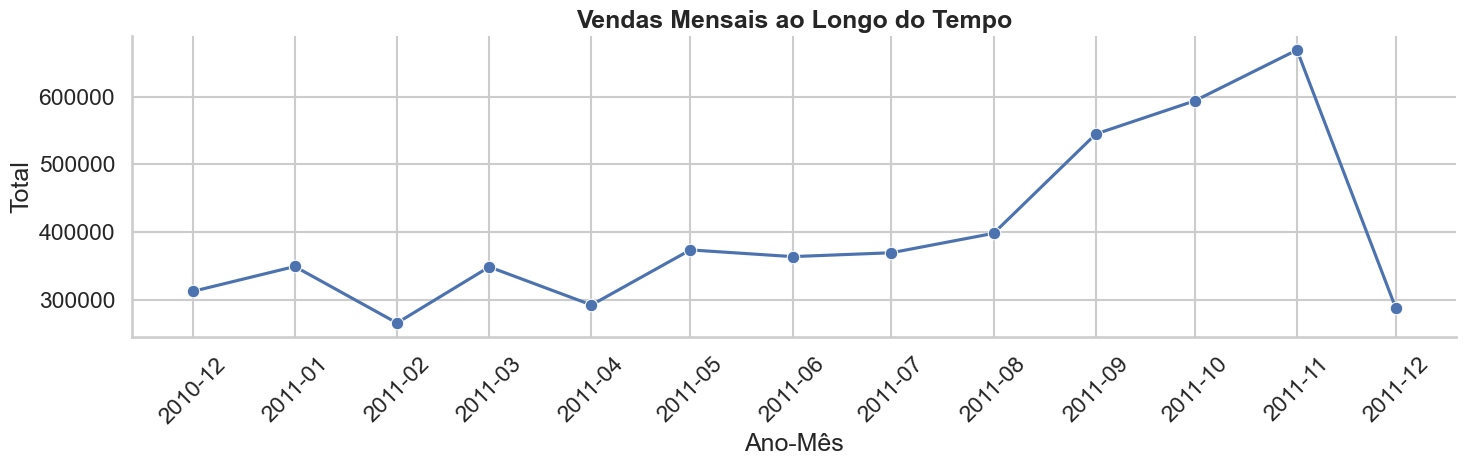

In [13]:
func.plot_vendas_mensais(df)

Observa-se que o conjunto de dados contempla transações no período de dezembro de 2010 a dezembro de 2011.

Para este projeto, optei por considerar apenas as vendas realizadas no ano de 2011, de modo a padronizar a análise em uma janela temporal completa de 12 meses. Essa delimitação garante maior consistência nos cálculos de Recência, Frequência e Valor Monetário, evitando distorções que poderiam ocorrer ao incluir períodos incompletos.

In [14]:
df = df[df['InvoiceDate'].dt.to_period('M') != '2010-12']

display(df)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
42481,42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.50
42482,42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.50
42483,42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.50
42484,42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,10.50
42485,42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,12.50
...,...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


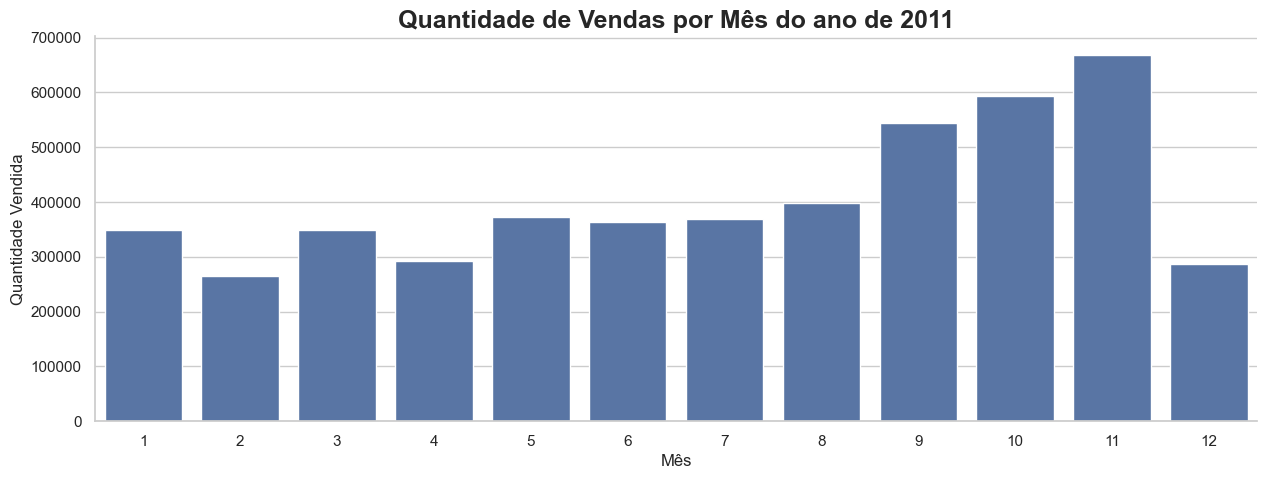

In [15]:
func.plot_vendas_ano(df)

<div style="background-color: #13678A; 
            color: white; 
            padding: 10px; 
            text-align: center;
            font-size: 20px;">
    <h1>2. Análise de RFM</h1>
</div>

## 2.1 Pontuação do RFM
A análise RFM é uma técnica de segmentação de clientes baseada no comportamento de compra, avaliando **Recência** (data da última compra), **Frequência** (quantidade de compras) e **Valor Monetário** (total gasto). Ela identifica os melhores clientes e os que precisam de atenção, permitindo campanhas de marketing personalizadas, maior fidelidade e aumento da receita. 

Componentes da Análise RFM:
- **Recência (R)**: Tempo decorrido desde a última compra. Clientes que compraram recentemente têm maior probabilidade de responder a novas ofertas.
- **Frequência (F)**: Número de compras realizadas em um determinado período. Compradores frequentes são mais leais e engajados.
- **Monetário (M)**: Total de dinheiro gasto pelo cliente. Clientes que gastam mais são valiosos para a receita. 

A análise RFM tem como objetivo agrupar clientes de acordo com seu comportamento de compra, avaliando quando compraram pela última vez, com que frequência compram e quanto gastam, ajudando a identificar os clientes mais relevantes para o negócio, engajados ou em risco de churn.

In [16]:
# Data da última compra
ultima_compra = df.groupby("CustomerID")["InvoiceDate"].max()

# Data de Referência
reference_date = df['InvoiceDate'].max() + dt.timedelta(days = 1)

# Criação das variáveis Recency, Frequency e MoneraryValue
recency = (reference_date - ultima_compra).dt.days
frequency = df.groupby("CustomerID")["InvoiceNo"].count()
monetary = df.groupby("CustomerID")["Total"].sum()

rfm = pd.DataFrame({
    "CustomerID": recency.index,
    "Recency": recency.values,
    "Frequency": frequency.values,
    "MonetaryValue": monetary.values 
})

#Pontuação baseada em quantis - Atribuição do rótulos de 1 a 5
#Recency
rfm["Recency Score"] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])

#Frequency score
rfm["Frequency Score"] = pd.qcut(rfm['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])

#Monetary score
rfm["Monetary Score"] = pd.qcut(rfm['MonetaryValue'].rank(method="first"),5, labels=[1, 2, 3, 4, 5])

display(rfm)

,CustomerID,Recency,Frequency,MonetaryValue,Recency Score,Frequency Score,Monetary Score
0,12346.0,326,1,77183.60,1,1,5
1,12347.0,2,151,3598.21,5,5,5
2,12348.0,75,14,904.44,2,1,3
3,12349.0,19,73,1757.55,4,4,4
4,12350.0,310,17,334.40,1,2,2
...,...,...,...,...,...,...,...
4214,18280.0,278,10,180.60,1,1,1
4215,18281.0,181,7,80.82,1,1,1
4216,18282.0,8,12,178.05,5,1,1
4217,18283.0,4,756,2094.88,5,5,5


In [17]:
#Combinação das pontuações de Recency, Frequency e MoneraryValue
rfm["RFM Segment"] = rfm['Recency Score'].astype(str) + rfm['Frequency Score'].astype(str) + rfm["Monetary Score"].astype(str)

# Soma das pontuções de Recency, Frequency e MoneraryValue
rfm["RFM Score"] = rfm[["Recency Score", "Frequency Score", "Monetary Score"]].sum(axis=1)

display(rfm)

,CustomerID,Recency,Frequency,MonetaryValue,Recency Score,Frequency Score,Monetary Score,RFM Segment,RFM Score
0,12346.0,326,1,77183.60,1,1,5,115,7
1,12347.0,2,151,3598.21,5,5,5,555,15
2,12348.0,75,14,904.44,2,1,3,213,6
3,12349.0,19,73,1757.55,4,4,4,444,12
4,12350.0,310,17,334.40,1,2,2,122,5
...,...,...,...,...,...,...,...,...,...
4214,18280.0,278,10,180.60,1,1,1,111,3
4215,18281.0,181,7,80.82,1,1,1,111,3
4216,18282.0,8,12,178.05,5,1,1,511,7
4217,18283.0,4,756,2094.88,5,5,5,555,15


Com as métricas de RFM estruturadas, podemos segmentar os clientes de forma estratégica, identificando grupos com comportamentos distintos e gerando insights para ações direcionadas.

Com base no RFM Score, os clientes foram segmentados em quatro níveis de valor **Bronze, Prata, Ouro e Platinum**, permitindo priorizar ações de retenção, fidelização e maximização de receita de acordo com o potencial de cada grupo. 

A categorização foi definida da seguinte forma:
- 3 a 5: Bronze
- 6 a 9: Prata
- 10 a 12: Ouro
- 13 a 15: Platinum

Essa divisão permite identificar diferentes níveis de valor e engajamento dos clientes, facilitando a definição de estratégias específicas para cada grupo.

In [18]:
#Definição dos intervalos (faixas) de classificação do RFM Score
bins = [0, 5, 9, 12, float('inf')]

#Definição dos rótulos (labels) correspondentes a cada faixa
labels = ["Bronze", "Prata", "Ouro", "Platinum"]

#Criação da coluna 'Segmento' com base na categorização do RFM Score
rfm["Segmento RFM"] = pd.cut(rfm["RFM Score"], bins=bins, labels=labels)

display(rfm)

,CustomerID,Recency,Frequency,MonetaryValue,Recency Score,Frequency Score,Monetary Score,RFM Segment,RFM Score,Segmento RFM
0,12346.0,326,1,77183.60,1,1,5,115,7,Prata
1,12347.0,2,151,3598.21,5,5,5,555,15,Platinum
2,12348.0,75,14,904.44,2,1,3,213,6,Prata
3,12349.0,19,73,1757.55,4,4,4,444,12,Ouro
4,12350.0,310,17,334.40,1,2,2,122,5,Bronze
...,...,...,...,...,...,...,...,...,...,...
4214,18280.0,278,10,180.60,1,1,1,111,3,Bronze
4215,18281.0,181,7,80.82,1,1,1,111,3,Bronze
4216,18282.0,8,12,178.05,5,1,1,511,7,Prata
4217,18283.0,4,756,2094.88,5,5,5,555,15,Platinum


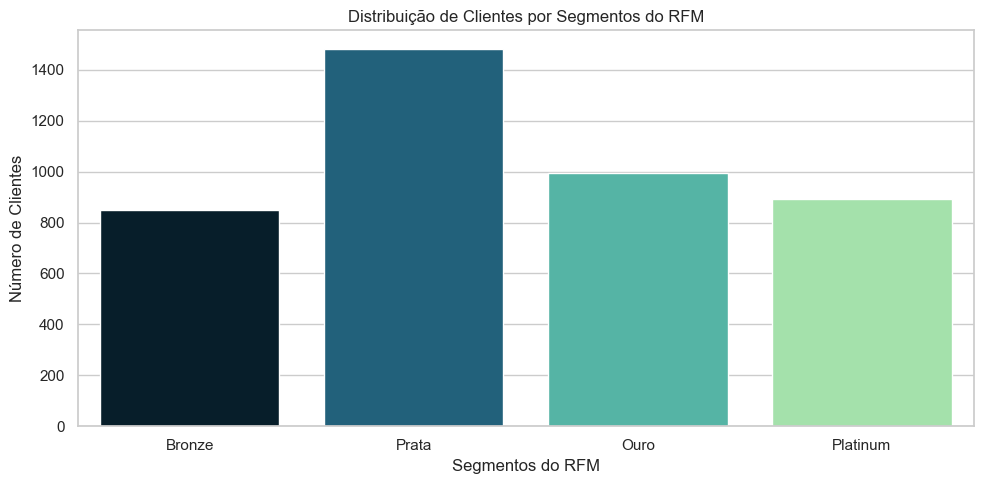

In [19]:
func.plot_rfm_segmentos(rfm, palette=Poseidon)

## 2.2 Matriz de RFM
Após o cálculo das pontuações de Recência, Frequência e Valor Monetário, construiremos a Matriz RFM, que permitirá classificar e distribuir os clientes de acordo com seus padrões de comportamento de compra.

A partir dessa matriz, os clientes podem ser segmentados nos seguintes grupos:

- **VIP (13–15)**: clientes que compraram recentemente, apresentam alta frequência de compra e elevado valor monetário. Representam os clientes de maior valor para o negócio.
- **Clientes Fiéis (10–12)**: apresentam boa frequência de compra e gasto consistente, embora não estejam necessariamente entre os maiores valores monetários.
- **Fiéis em Potencial (7–9)**: clientes com compras recentes, que já realizaram mais de uma transação e demonstram potencial de aumento no valor gasto.
- **Novos Clientes (4–6)**: realizaram compras recentemente, porém ainda apresentam baixa frequência e menor valor monetário.
- **Atenção  (3)**: clientes com baixa recência (não compram há algum tempo), baixa frequência e baixo valor monetário, indicando risco de churn.

Essa segmentação permite direcionar estratégias específicas para retenção, fidelização e reativação, de acordo com o perfil comportamental de cada grupo.

In [20]:
rfm["Segmento Clientes"] = " "

rfm.loc[rfm["RFM Score"] >= 13, "Segmento Clientes"] = "VIP"
rfm.loc[(rfm["RFM Score"] >= 10) & (rfm["RFM Score"] <= 12), "Segmento Clientes"] = "Clientes Fiéis"
rfm.loc[(rfm["RFM Score"] >= 7) & (rfm["RFM Score"] <= 9), "Segmento Clientes"] = "Fiéis em Potencial"
rfm.loc[(rfm["RFM Score"] >= 4) & (rfm["RFM Score"] <= 6), "Segmento Clientes"] = "Novos Clientes"
rfm.loc[(rfm["RFM Score"] >= 2) & (rfm["RFM Score"] <= 3), "Segmento Clientes"] = "Atenção"

segment_counts = rfm["Segmento Clientes"].value_counts().sort_index()

segment_product_counts = rfm.groupby(["Segmento RFM", "Segmento Clientes"]).size().reset_index(name="Count")

segment_product_counts = segment_product_counts.sort_values("Segmento RFM", ascending=True)

fig_treemap_segment_product = px.treemap(segment_product_counts,
                                         path=["Segmento RFM", "Segmento Clientes"],
                                         values="Count",
                                         color="Segmento RFM",
                                         color_discrete_sequence=px.colors.qualitative.Plotly,
                                         title="Segmentos de Clientes RFM por Categoria")
fig_treemap_segment_product.show()

O GitHub não renderiza gráficos interativos do Plotly (como os gerados pelo plotly.express) diretamente em arquivos `.ipynb`. Isso ocorre porque a visualização do notebook na plataforma é estática e não executa JavaScript, recurso necessário para a renderização dos gráficos interativos.

Para garantir melhor visualização dos resultados, será disponibilizada uma versão estática dos gráficos em formato `.png`.

![alt text](img/rfm_categoria.png)

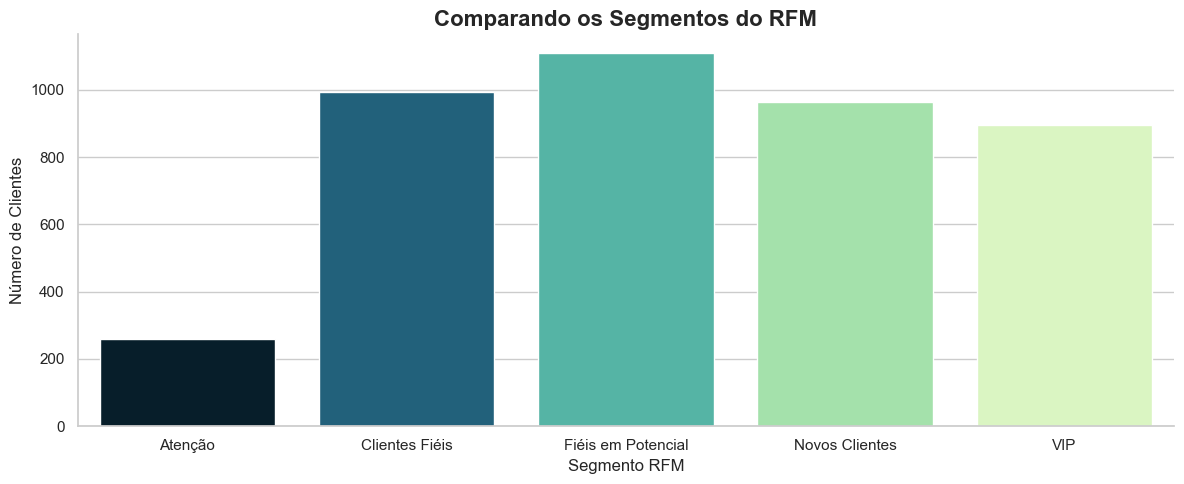

In [21]:
func.plot_segmentos_rfm(rfm, palette=Poseidon)

## 2.3 Correlação entre as Pontuações RFM no Segmento VIP

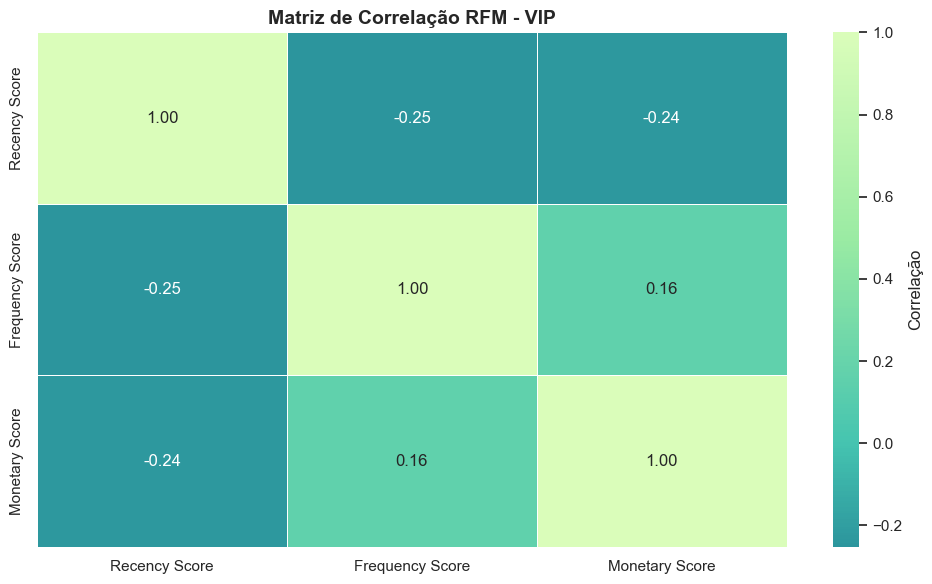

In [22]:
func.plot_heatmap_correlacao_rfm(rfm, palette=Poseidon)

A correlação entre Recency Score e Frequency Score no segmento VIP apresentou valor de -0.23, indicando uma relação negativa fraca. Esse resultado sugere que, dentro desse grupo, não há uma associação forte entre frequência de compras e recência, possivelmente devido à homogeneidade do segmento ou à existência de diferentes perfis comportamentais dentro dos clientes de alto valor. Ou seja, podem existem clientes que alta frequência, mas não necessariamente comprou nos último dias ou VIPs que realizou compras recentes e de alto valor, mas que possuem frequência menor.

<div style="background-color: #13678A; 
            color: white; 
            padding: 10px; 
            text-align: center;
            font-size: 20px;">
    <h1>3. Clusterização</h1>
</div>

Outra forma de segmentar clientes é por meio de algoritmos de Machine Learning, especialmente técnicas de Clustering (ou Clusterização). Trata-se de um método de aprendizado não supervisionado que tem como objetivo agrupar dados semelhantes em conjuntos chamados clusters, de modo que os elementos dentro de um mesmo grupo sejam mais parecidos entre si do que em relação aos elementos de outros grupos.

Na seção anterior, a segmentação foi realizada manualmente com base no modelo RFM. Nesta etapa, será aplicada uma abordagem orientada por dados utilizando algoritmos de clusterização, com o objetivo de analisar possíveis mudanças no comportamento dos clientes e comparar os resultados obtidos com a segmentação tradicional. 

Enquanto o modelo RFM realiza uma segmentação estruturada com base em critérios estabelecidos (Recência, Frequência e Valor Monetário), a aplicação de algoritmos de clustering possibilita descobrir agrupamentos naturais nos dados. Isso permite analisar se os padrões comportamentais identificados pelo modelo tradicional se mantêm ou se surgem novas dinâmicas de segmentação quando a análise é orientada exclusivamente pelos dados.

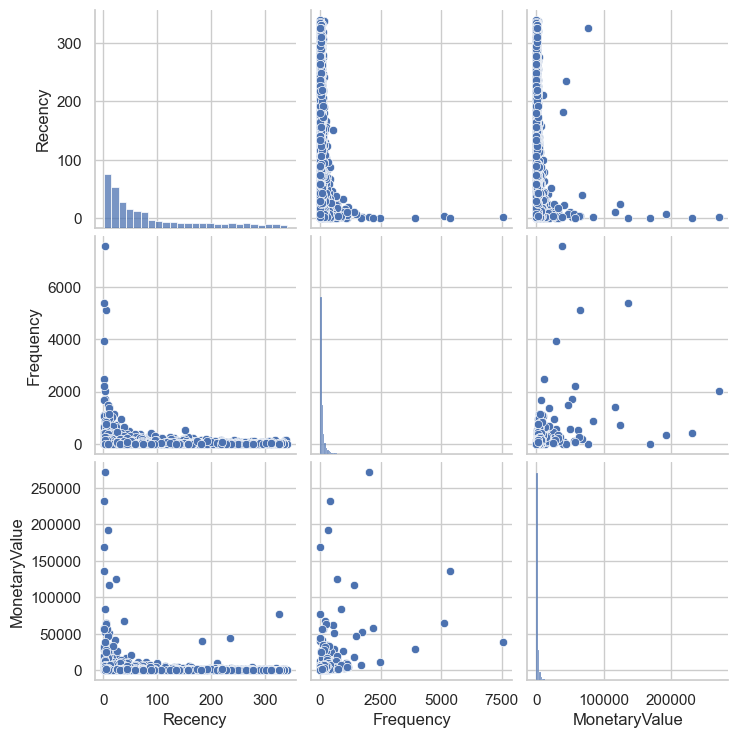

In [23]:
sns.pairplot(rfm[["Recency", "Frequency", "MonetaryValue"]])
plt.show()

## 3.1 Recency vs MonetaryValue
A segmentação dos clientes será realizada por meio de um algoritmo de clusterização não supervisionado, considerando as variáveis Recency (tempo desde a última compra) e Monetary Value (valor total gasto), derivadas do modelo RFM.

Para definir o número ideal de grupos, será aplicado o Método do Cotovelo, que permite identificar a quantidade adequada de clusters a partir da análise da variação da soma das distâncias intra-cluster.

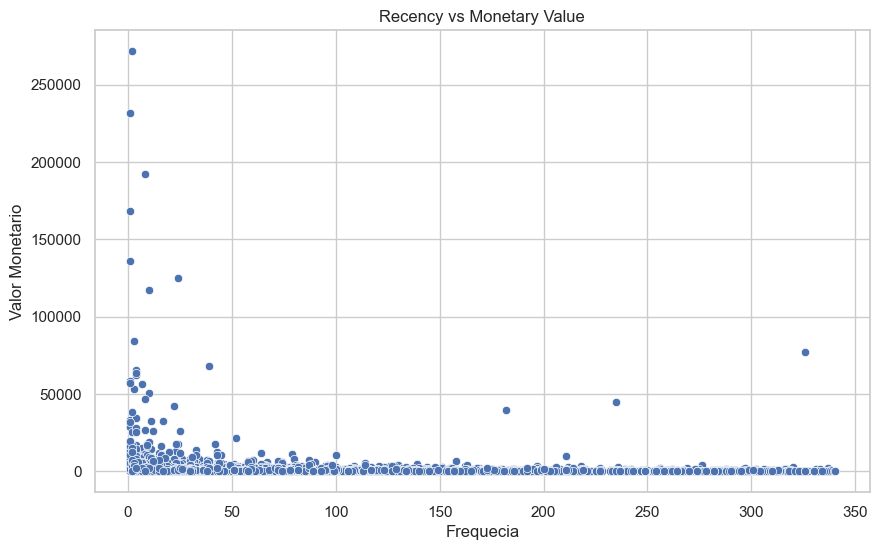

In [24]:
# Gráfico das variáveis Recency e MonetaryValue
plt.figure(figsize=(10,6))
sns.scatterplot(x="Recency" , y ="MonetaryValue", data= rfm)
plt.xlabel("Frequecia")
plt.ylabel("Valor Monetario")
plt.title("Recency vs Monetary Value")
plt.show()

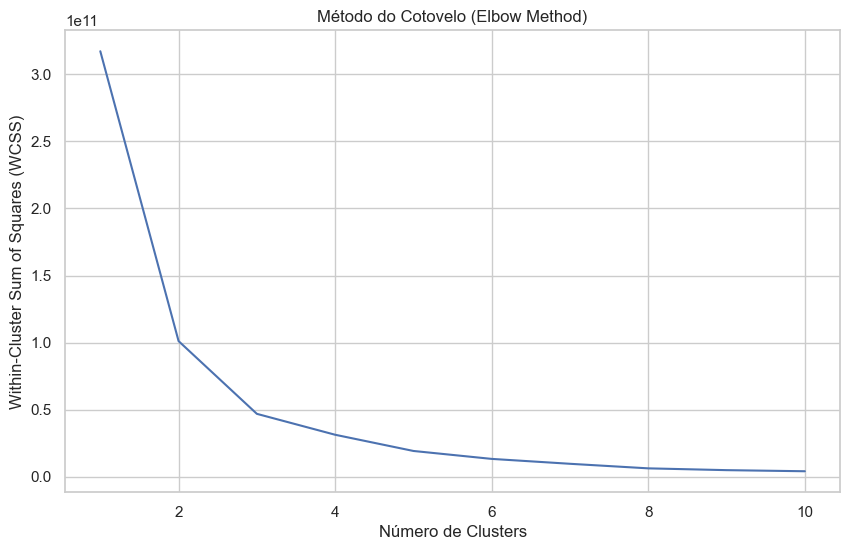

In [25]:
from sklearn.cluster import KMeans

X = rfm[["Recency", "MonetaryValue"]]

valores_k = []  #Within-Cluster Sum of Squares (WCSS) - soma dos quadrados dentro do cluster

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    valores_k.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,11), valores_k)
plt.xlabel("Número de Clusters")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Método do Cotovelo (Elbow Method)")
plt.show()

O ponto de inflexão do gráfico indica o número de clusters que melhor equilibra a complexidade do modelo e sua capacidade de representar adequadamente a estrutura dos dados.

Neste caso, os valores k = 3 e k = 4 apresentam-se como opções promissoras. Para uma avaliação mais criteriosa, ambos os cenários foram testados e seus resultados serão comparados a fim de identificar a segmentação mais consistente e interpretável.

In [27]:
kmeans3 = KMeans(n_clusters=3, init="k-means++", max_iter=300, n_init=10, random_state=0)
y_kmeans3 = kmeans3.fit_predict(X)

rfm["Cluster (3) RxM"] = y_kmeans3

kmeans4 = KMeans(n_clusters=4, init="k-means++", max_iter=300, n_init=10, random_state=0)
y_kmeans4 = kmeans4.fit_predict(X)

rfm["Cluster (4) RxM"] = y_kmeans4

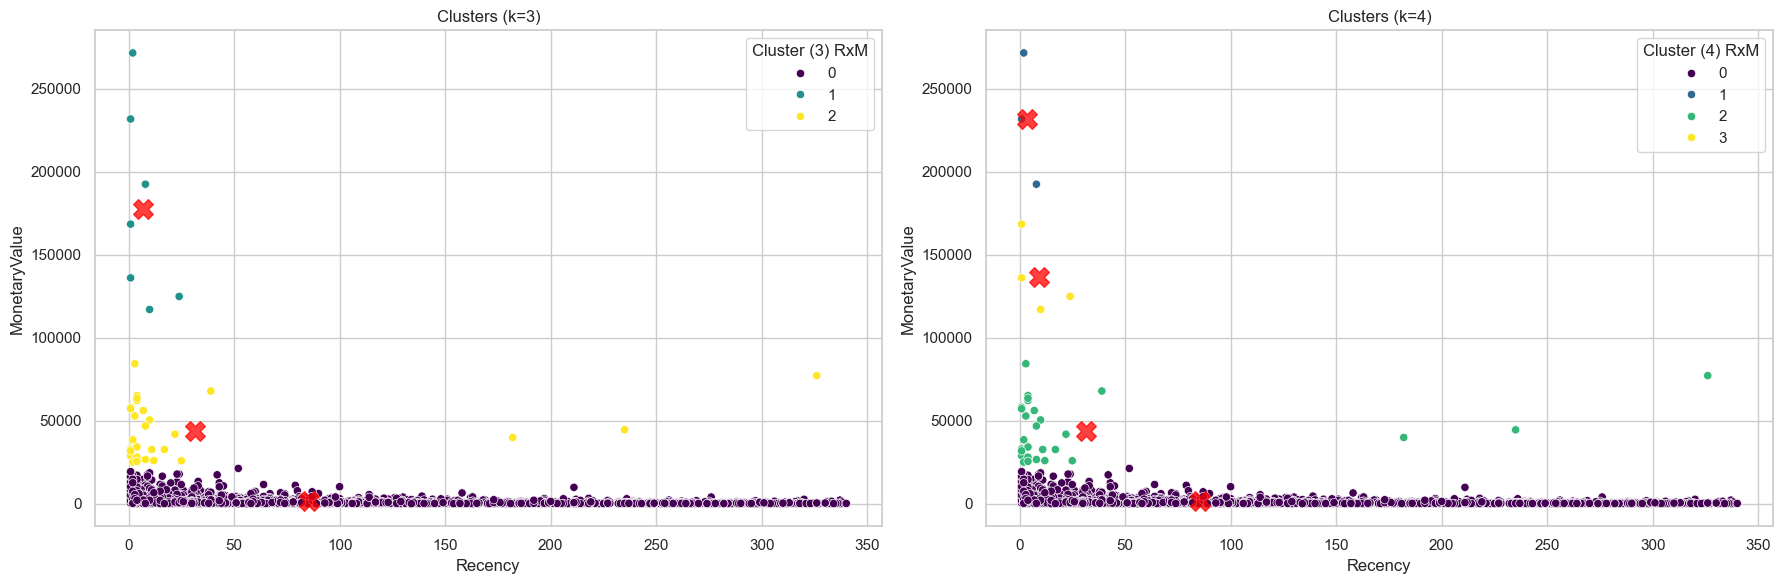

In [28]:
fig, ax = plt.subplots(ncols = 2, figsize=(18,6))

# ----- Cluster com 3 grupos -----
sns.scatterplot(x = 'Recency', y = 'MonetaryValue', hue = 'Cluster (3) RxM', data = rfm, palette = 'viridis', ax=ax[0])
centers = kmeans3.cluster_centers_
ax[0].scatter(centers[:,0], centers[:,1], c="red", s=200, alpha=0.75, marker="X")
ax[0].set_title("Clusters (k=3)")
ax[0].set_xlabel("Recency")
ax[0].set_ylabel("MonetaryValue")

# ----- Cluster com 4 grupos -----
sns.scatterplot(x = 'Recency', y = 'MonetaryValue', hue = 'Cluster (4) RxM', data = rfm, palette = 'viridis', ax = ax[1])
centers = kmeans4.cluster_centers_
ax[1].scatter(centers[:,0], centers[:,1], c="red", s=200, alpha=0.75, marker="X")
ax[1].set_title("Clusters (k=4)")
ax[1].set_xlabel("Recency")
ax[1].set_ylabel("MonetaryValue")

plt.tight_layout()
plt.show()

Ao comparar os modelos com k=3 e k=4, observa-se que o aumento do número de clusters proporciona uma segmentação mais detalhada, especialmente na separação de clientes de alto valor monetário.
Em ambos os cenários, nota-se a predominância de um grande grupo composto por clientes de baixo valor e maior recência, indicando um segmento menos engajado.

No modelo com k=4, há uma separação mais evidente dos clientes de alto ticket, sugerindo a identificação de um possível segmento premium. Entretanto, a forte dispersão do eixo monetário indica presença de valores extremos que podem estar influenciando a formação dos clusters.